In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Prepare dataset
cancer = load_breast_cancer()
X = cancer['data']
y = cancer['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define black box function to optimize
def black_box_function(C): # C: SVC hyperparameter to optimize for
    model = SVC(C = C)
    model.fit(X_train_scaled, y_train)
    y_score = model.decision_function(X_test_scaled)
    f = roc_auc_score(y_test, y_score)
    return f

# Set range of C to optimize for (bayes_opt req this to be a dict)
pbounds = {'C': [0.01, 10]}

# Create Bayes optimizer to optimize black box func
optimizer = BayesianOptimization(f = black_box_function, pbounds=pbounds, verbose=2, random_state=4)
optimizer.maximize(init_points=5, n_iter=10)
print('Best result: {}; f(x) = {}.'.format(optimizer.max['params'], optimizer.max['target']))

|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.9979    | 9.671     |
| 2         | 0.9975    | 5.477     |
| 3         | 0.9979    | 9.727     |
| 4         | 0.9979    | 7.151     |
| 5         | 0.9979    | 6.98      |
| 6         | 0.987     | 0.01235   |
| 7         | 0.9981    | 8.462     |
| 8         | 0.9981    | 8.103     |
| 9         | 0.9981    | 8.282     |
| 10        | 0.9981    | 8.776     |
| 11        | 0.9977    | 6.214     |
| 12        | 0.9973    | 4.048     |
| 13        | 0.9981    | 8.635     |
| 14        | 0.9981    | 7.923     |
| 15        | 0.9981    | 8.964     |
Best result: {'C': 8.461966936485059}; f(x) = 0.9981132075471698.


More Control Over the Optimization Process

Best result: {'C': 9.984215837074222, 'degree': 4.0}; f(x) = 0.998.


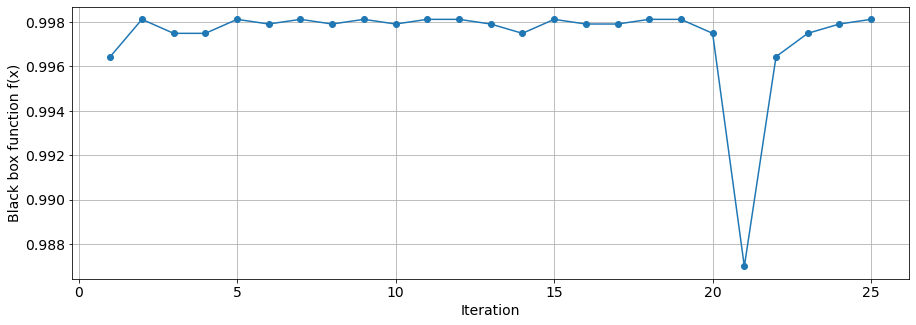

In [11]:
# Create the optimizer. The black box function to optimize is not
# specified here, as we will call that function directly later on.
optimizer = BayesianOptimization(f = None, 
                                 pbounds = {"C": [0.01, 10], 
                                            "degree": [1, 5]}, 
                                 verbose = 2, random_state = 1234)
# Specify the acquisition function (bayes_opt uses the term
# utility function) to be the upper confidence bounds "ucb".
# We set kappa = 1.96 to balance exploration vs exploitation.
# xi = 0.01 is another hyper parameter which is required in the
# arguments, but is not used by "ucb". Other acquisition functions
# such as the expected improvement "ei" will be affected by xi.
utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)
# We want to optimize both C and degree simultaneously.
def black_box_function(C, degree):
    model = SVC(C = C, degree = degree)
    model.fit(X_train_scaled, y_train)
    y_score = model.decision_function(X_test_scaled)
    f = roc_auc_score(y_test, y_score)
    return f
# Optimization for loop.
for i in range(25):
    # Get optimizer to suggest new parameter values to try using the
    # specified acquisition function.
    next_point = optimizer.suggest(utility)
    # Force degree from float to int.
    next_point["degree"] = int(next_point["degree"])
    # Evaluate the output of the black_box_function using 
    # the new parameter values.
    target = black_box_function(**next_point)
    try:
        # Update the optimizer with the evaluation results. 
        # This should be in try-except to catch any errors!
        optimizer.register(params = next_point, target = target)
    except:
        pass
print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
plt.figure(figsize = (15, 5))
plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, "-o")
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Black box function f(x)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()